In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:32, 946.14it/s] 


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[2]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Двойное списание за один товар.',
 'num_comments': 1,
 'bank_license': 'лицензия № 2562',
 'author': 'Vladimir84',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-05 20:14:28',
 'text': 'Здравствуйте! \xa0Дублирую свое заявление от 03.06.2015 в ДО "Можайский". \xa002.06.2015 мною, по моей дебетовой карте была совершена покупка в интернет-магазине \xa0на сумму 3028 руб., но с карты произошло двойное списание (два раза по 3028 руб.) то есть 6056 руб. (о чем имеются смс сообщения от банка). Интернет-магазин подтвердил только один платеж 3028 руб. , товар был получен 05.06.2015. Прошу разобраться в ситуации и вернуть мне на счет ошибочно списанную сумму в размере 3028 руб.!  \xa0С уважением, давний клиент Вашего банка Владимир. Номер карты указан в моем заявлении в\xa0ДО "Можайский".',
 'rating_grade': None}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

1.1 Количество отзывов для разных банков

In [5]:
banks=[]
for i in range(len(responses)):
    banks.append(responses[i]['bank_name'])

In [6]:
pd.DataFrame(banks)[0].value_counts()[:10]

Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: 0, dtype: int64

1.2. Количество отзывов из разных городов

In [7]:
cities=[]
for i in range(len(responses)):
    cities.append(responses[i]['city'])

In [8]:
pd.DataFrame(cities)[0].value_counts()[:10]

г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: 0, dtype: int64

1.2.1. Длина текста в символах

In [9]:
symbol_count=[]
for i in range(len(responses)):
    symbol_count.append(len(responses[i]['text']))

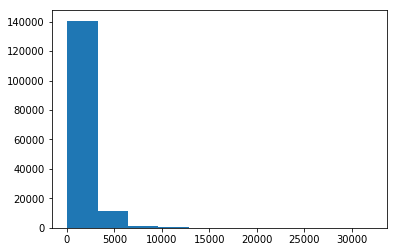

In [10]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(symbol_count)

1.2.2. Длина текста в словах

In [11]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [12]:
feedback=[]
for i in range(len(responses)):
    feedback.append(responses[i]['text'])
feedback_for_an=[words_only(x.lower()) for x in feedback]

In [13]:
feedback_for_an[1]

'доброго дня являюсь держателем зарплатной карты выданной сбербанком россии в году сменила фамилию предоставила в банк документы копию нового паспорта свидетельства о браке мне перевыпустили карту на фамилию мужа токарева мария александровна девичья секлетина возникла необходимость подключить услугу сбербанк онлайн не получилось на главной странице на отображались мои карты связалась с техническим специалистом отделения сбербанка в котором обслуживалась он пояснил что в базе банка я все ещ под девичьей фамилией секлетина предложил выслать сканы необходимых документов выслала оставив контакты звонка так и не дождалась ч з некоторое время звоню сама объясняю ситуацию меня пробивают по базе опять числюсь секлетиной хотя карту уже перевыпустили еще раз на фамилию токарева в связи с истечением срока обслуживания высылаю документы копию паспорта и свидетельства о браке результат ноль прошу помочь разобраться в этой ситуации с уважением токарева мария александровна'

In [14]:
words_length=[x.replace(' ',',').split(',') for x in feedback_for_an]

In [15]:
words_count=[]
for i in range(len(responses)):
    words_count.append(len(words_length[i]))

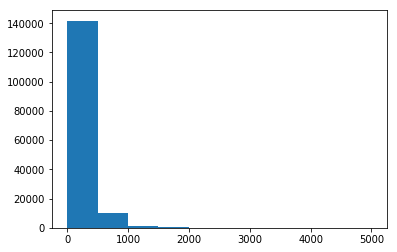

In [16]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(words_count)

1.3.1 10 самых частых слов

In [17]:
words_length2=[x.replace(' ',',') for x in feedback_for_an]

In [18]:
words=','.join(words_length2)

In [19]:
words=words.split(',')

In [20]:
import collections

In [21]:
collections.Counter(words).most_common(10)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

1.3.2 10 самых частых слов без стоп-слов

In [22]:
from nltk.corpus import stopwords

In [23]:
noise = stopwords.words('russian')
#Нужно было бы расширить список стоп-слов, и добавить "это", тк это потом пригодится
noise=noise+['наш' ,'это', 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
words2=[x for x in words if x not in noise]

In [24]:
collections.Counter(words2).most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824)]

In [25]:
words2=[x for x in words2 if len(x)>2]

1.3.3 10 самых частых лемм

In [26]:
count_l=collections.Counter(words2).most_common(100)

In [27]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Mystem очень сложная для винды библиотека, поэтому я возьму 100 самых используемых слов, приеобразую их в леммы и найду топ 10 лемм

В этом случае он не сможет использовать контекст

In [28]:
top100words_tab=pd.DataFrame(count_l)

In [29]:
top100words=' '.join(top100words_tab[0].values.tolist())

In [30]:
top100words_lemm=mystem_analyzer.lemmatize(top100words)

In [31]:
top100words_lemm=[x for x in top100words_lemm if x!=' ']

In [32]:
top100words_lemm=['банк'  if x=='банка' else x for x in top100words_lemm]

In [33]:
top100words_lemm.remove('\n')

In [34]:
top100words_tab[0]=top100words_lemm

In [35]:
top100words_tab=top100words_tab.groupby([0]).sum().sort_values(by=[1],ascending=False)

In [36]:
top10lemm=top100words_tab[:10]

In [37]:
top10lemm

,1
0,
банк,631568
карта,293839
деньги,173346
день,163710
отделение,131658
кредит,118149
счет,96344
сотрудник,95357
время,91586


PS RNN predictor не смог импортироваться на моем компе, mystem не считался в колабе (не знаю почему), но mystem на компе сделал лучше результат,чем rnn в колабе. Поэтому исп mystem

1.4. top 10 существительных

почти все слова в топ 10 лемм существительные, можно взять 30 лематизированных слов из top100words и выбрать из них существительные

In [38]:
words_for_an=top100words_tab.index.tolist()[:30]

In [39]:
nouns=[x for x in words_for_an if 'S' in mystem_analyzer.analyze('молоко')[0]['analysis'][0]['gr']]

In [40]:
nouns[:10]

['банк',
 'карта',
 'деньги',
 'день',
 'отделение',
 'кредит',
 'счет',
 'сотрудник',
 'время',
 'мой']

In [41]:
nouns.remove('мой')

In [42]:
nouns[:10]

['банк',
 'карта',
 'деньги',
 'день',
 'отделение',
 'кредит',
 'счет',
 'сотрудник',
 'время',
 'сумма']

1.5.Постройте кривые Ципфа и Хипса

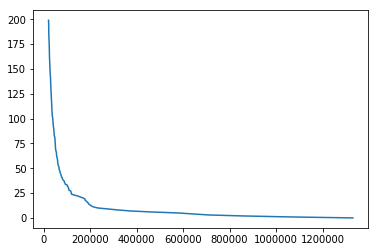

In [43]:
#Ципф
freqs = list(collections.Counter(words).values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:200], range(200))
plt.show()

In [44]:
n_tokens=words_count

In [45]:
n_types=[len(collections.Counter(x)) for x in words_length]

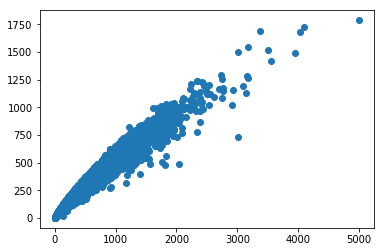

In [46]:
#Xипс
fig, ax = plt.subplots()
ax.scatter(n_tokens, n_types)
plt.show()

1.6.1.Клиент или сотрудник?

In [47]:
dict_w=dict(collections.Counter(words2))

In [48]:
top100words_tab[top100words_tab.index=='сотрудник']

,1
0,
сотрудник,95357


In [49]:
top100words_tab[top100words_tab.index=='клиент']

,1
0,
клиент,56673


In [50]:
dict_w['клиент']+dict_w['клиенту']+dict_w['клиенте']+dict_w['клиентом']+dict_w['клиента']+dict_w['клиенты']+dict_w['клиентов']+dict_w['клиентам']+dict_w['клиентами']+dict_w['клиентах']

136892

In [51]:
dict_w['сотрудник']+dict_w['сотруднике']+dict_w['сотрудника']+dict_w['сотрудником']+dict_w['сотрудники']+dict_w['сотрудников']+dict_w['сотрудникам']+dict_w['сотрудниками']+dict_w['сотрудниках']

129166

По леммам получается неверно, тк использовали топ100 частых слов, надо было больше лемматизировать, плюс могли быть ошибки в самих леммах

клиент

1.6.2.Доверие или мошенничество?

In [52]:
dict_w['доверие']+dict_w['доверия']+dict_w['доверию']+dict_w['доверием']+dict_w['доверии']

2107

In [53]:
dict_w['мошенничество']+dict_w['мошеничества']+dict_w['мошенничеству']+dict_w['мошенничеством']+dict_w['мошенничестве']

1951

доверие

1.7.ключевые слова и биграммы с помощью tf-idf

In [54]:
#возьмем 500 положительных отзывов

In [55]:
grade5=[x['text'] for x in responses if x['rating_grade']==5][:500]

In [56]:
grade5=[words_only(x.lower()) for x in grade5]

In [57]:
words_grade5=[x.replace(' ',',') for x in grade5]

In [58]:
words_grade5=','.join(words_grade5)

In [59]:
words_grade5=words_grade5.split(',')

In [60]:
grade5=[x for x in words_grade5 if x not in noise]

In [61]:
grade5=[x for x in grade5 if len(x)>2]

In [62]:
len(grade5)

56166

In [63]:
i=0
grade5_lem=[]
while i<len(grade5):
    print(i)
    grade=' '.join(grade5[i:(i+100)])
    grade5_for_lem=mystem_analyzer.lemmatize(grade)
    grade5_lem=grade5_lem+grade5_for_lem
    i=i+100

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [64]:
len(grade5_lem)

112332

In [65]:
grade5_lem=[x for x in grade5_lem if x!=' ']

In [66]:
grade5_lem=[x for x in grade5_lem if x!='\n']

In [67]:
len(grade5_lem)

56166

In [68]:
#возьмем 500 отрицательных отзывов

In [69]:
grade1=[x['text'] for x in responses if x['rating_grade']==1][:500]

In [70]:
grade1=[words_only(x.lower()) for x in grade1]

In [71]:
words_grade1=[x.replace(' ',',') for x in grade1]

In [72]:
words_grade1=','.join(words_grade1)

In [73]:
words_grade1=words_grade1.split(',')

In [74]:
grade1=[x for x in words_grade1 if x not in noise]

In [75]:
grade1=[x for x in grade1 if len(x)>2]

In [76]:
len(grade1)

74397

In [77]:
i=0
grade1_lem=[]
while i<len(grade1):
    print(i)
    grade=' '.join(grade1[i:(i+100)])
    grade1_for_lem=mystem_analyzer.lemmatize(grade)
    grade1_lem=grade1_lem+grade1_for_lem
    i=i+100

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [78]:
grade1_lem=[x for x in grade1_lem if x!=' ']

In [79]:
grade1_lem=[x for x in grade1_lem if x!='\n']

In [80]:
len(grade1_lem)

74397

In [81]:
for_keyw=[]
for_keyw.append(' '.join(grade5_lem))
for_keyw.append(' '.join(grade1_lem))

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [83]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(for_keyw)

In [84]:
tab_grade=pd.concat([pd.DataFrame(vectorizer.get_feature_names()),pd.DataFrame(X[0].toarray()[0]),pd.DataFrame(X[1].toarray()[0])],axis=1)

In [85]:
tab_grade.columns=['word','tf_5', 'tf_1']

In [86]:
tab_grade.sort_values(by='tf_5',ascending=False)[:50]

,word,tf_5,tf_1
1567,банк,0.598212,0.495378
29065,карта,0.306990,0.338600
83538,сотрудник,0.148966,0.168298
55042,очень,0.141585,0.034060
30685,клиент,0.140914,0.119462
16382,день,0.136217,0.174309
38514,мой,0.133197,0.149515
7597,вклад,0.130177,0.074632
52057,отделение,0.125816,0.162538
32730,который,0.124809,0.141751


In [87]:
tab_grade['%key']=tab_grade['tf_5']/tab_grade['tf_1']

In [88]:
positive_words=tab_grade[tab_grade['tf_1']>0].sort_values(by='%key', ascending=False)[:100]['word'].values.tolist()

In [89]:
positive_words[:30]

['миля',
 'хотеть выражать',
 'благодарность',
 'приятно удивлять',
 'приятно',
 'понравиться',
 'внимательный',
 'выражать',
 'огромный спасибо',
 'приветливый',
 'очень удобный',
 'спасибо банка',
 'рейтинг',
 'удача',
 'пожелание',
 'проявлять',
 'балл',
 'порадовать',
 'очень приятно',
 'улыбка',
 'пример',
 'много',
 'профессиональный',
 'хотеть сказать',
 'сотрудничать',
 'очень довольный',
 'привлекательный',
 'банк спасибо',
 'благодарный',
 'охранник']

In [90]:
tab_grade['%key_neg']=tab_grade['tf_1']/tab_grade['tf_5']

In [91]:
negative_words=tab_grade[tab_grade['tf_5']>0].sort_values(by='%key_neg', ascending=False)[:100]['word'].values.tolist()

In [92]:
negative_words[:30]

['росбанк',
 'нарушать',
 'контактный',
 'просить разбираться',
 'договор страхование',
 'распечатка',
 'названивать',
 'сумма который',
 'заключать',
 'соответствие',
 'закон',
 'уверять',
 'обман',
 'почему должный',
 'ответ банк',
 'зарегистрировать',
 'нарушение',
 'сертификат',
 'принадлежать',
 'принимать мера',
 'книга',
 'некомпетентный',
 'вынужденный',
 'сказать карта',
 'отвратительный',
 'возмущение',
 'заявление выпуск',
 'автосалон',
 'карта деньги',
 'аннулировать']

2.1 Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [93]:
#Возьмем 500 первых отзывов

In [94]:
data_for_latterm=[x['text'] for x in responses[:500]]

In [95]:
data_for_latterm=[words_only(x.lower()) for x in data_for_latterm]

In [96]:
data_for_latterm=[x.replace(' ',',').split(',') for x in data_for_latterm]

In [97]:
latterm_wo_stopw=[]
for i in data_for_latterm:
    latterm_wo_stopw.append(' '.join([x for x in i if x not in noise]))

In [98]:
latterm_wo_stopw[0]

'добрый день являюсь клиентом банка поручителем кредитному договору являюсь каким либо другим лицом письменно оформившим отношения банком поводу урегулирования чьей либо задолженности начиная марта года начали приходить бесконечные письма ооо примо коллект адрес город москва уваровский переулок дом квартира угрозами возбуждении уголовного дела отношении гражданина филиппова эдуарда владимировича который уклоняется уплаты взятых кредитов договор года договор года всей ответственностью хочу заверить вышеуказанный гражданин которого разыскиваете знаком моем адресе зарегистрирован каким образом удостоверившись подлинности документов оформили имя кредитный договор меньшей мере понятно почему вашей милости должна переживать бояться свое имущество письма доставляют серьезные неудобства нарушают мои гражданские права нарушают закон защите персональных данных убедительно прошу прекратить посылать адрес письма угрозами вопросам которым имею отношения случае отклонения моей претензии буду вынужде

In [99]:
latterm_lem=[mystem_analyzer.lemmatize(x) for x in latterm_wo_stopw]

In [100]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', ' ', '\n']
latterm=[]
for i in tqdm(latterm_lem):
    latterm.append([x for x in i if x not in mystoplemmas])

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 8413.61it/s]


In [101]:
latterm2=[]
for i in tqdm(latterm_lem):
    latterm2.append([x for x in i if len(x)>2])

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 25424.96it/s]


In [103]:
latterm_lem=latterm2

In [104]:
from gensim.corpora import *

C:\Users\volko\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [105]:
dictionary = Dictionary(latterm)

In [106]:
from gensim.models import  *

In [107]:
corpus = [dictionary.doc2bow(x) for x in latterm]

In [108]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [109]:
%%time
lsi = lsimodel.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 9min 34s


In [110]:
lsi.show_topics(5)

[(0,
  '0.181*"вклад" + 0.180*"карта" + 0.151*"кредит" + 0.108*"договор" + 0.106*"сумма" + 0.104*"счет" + 0.100*"деньги" + 0.099*"мой" + 0.097*"сотрудник" + 0.097*"ставка"'),
 (1,
  '0.508*"вклад" + 0.327*"ставка" + 0.252*"пополнение" + 0.193*"условие" + 0.133*"изменение" + 0.133*"договор" + 0.132*"односторонний" + 0.127*"пополнять" + 0.115*"процентный" + -0.114*"кредит"'),
 (2,
  '-0.239*"звонок" + 0.214*"карта" + -0.213*"номер" + -0.191*"телефон" + -0.164*"данные" + -0.155*"согласие" + -0.147*"персональный" + -0.147*"удалять" + -0.145*"прекращать" + -0.144*"звонить"'),
 (3,
  '-0.425*"страховка" + -0.369*"страхование" + -0.307*"кредит" + 0.186*"карта" + -0.155*"договор" + -0.145*"отказываться" + -0.110*"документ" + 0.104*"номер" + -0.101*"отказ" + 0.098*"телефон"'),
 (4,
  '0.266*"задолженность" + 0.189*"объем" + 0.181*"форс" + 0.181*"мажор" + 0.172*"доводить" + 0.167*"предполагаться" + 0.160*"средство" + 0.160*"ответственный" + 0.155*"временный" + 0.154*"просрочка"')]

тема 1 - изменение условий по вкладу в одностороннем порядке
тема 4- возникла задолженность по причине форсмажора

In [111]:
lsi = lsimodel.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)

In [112]:
lsi.show_topics(5)

[(0,
  '0.181*"вклад" + 0.180*"карта" + 0.151*"кредит" + 0.108*"договор" + 0.106*"сумма" + 0.104*"счет" + 0.100*"деньги" + 0.099*"мой" + 0.097*"сотрудник" + 0.097*"ставка"'),
 (1,
  '0.507*"вклад" + 0.327*"ставка" + 0.253*"пополнение" + 0.193*"условие" + 0.134*"изменение" + 0.132*"договор" + 0.132*"односторонний" + 0.127*"пополнять" + 0.115*"процентный" + -0.114*"кредит"'),
 (2,
  '-0.239*"звонок" + -0.215*"номер" + 0.215*"карта" + -0.193*"телефон" + -0.163*"данные" + -0.154*"согласие" + -0.148*"персональный" + -0.145*"звонить" + -0.145*"удалять" + -0.144*"прекращать"'),
 (3,
  '-0.425*"страховка" + -0.370*"страхование" + -0.306*"кредит" + 0.185*"карта" + -0.157*"договор" + -0.141*"отказываться" + 0.106*"номер" + -0.105*"документ" + -0.100*"отказ" + 0.097*"телефон"'),
 (4,
  '-0.269*"задолженность" + -0.187*"объем" + -0.179*"форс" + -0.179*"мажор" + -0.171*"доводить" + -0.163*"предполагаться" + -0.162*"средство" + -0.159*"ответственный" + -0.155*"просрочка" + -0.155*"погашение"')]

тема 2- звонили, предлагади карту, нарушение закона о персональных данных

In [113]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

Wall time: 10.9 s


In [114]:
lda.show_topics(5)

[(9,
  '0.007*"мой" + 0.006*"окно" + 0.006*"квитанция" + 0.005*"сотрудник" + 0.005*"оплата" + 0.004*"банк" + 0.004*"знакомый" + 0.004*"номер" + 0.004*"требовать" + 0.004*"человек"'),
 (18,
  '0.006*"оператор" + 0.006*"сбербанк" + 0.006*"депозит" + 0.005*"деньги" + 0.004*"банк" + 0.004*"средство" + 0.004*"карточка" + 0.004*"просить" + 0.004*"звонить" + 0.004*"город"'),
 (24,
  '0.024*"карта" + 0.024*"банк" + 0.013*"мой" + 0.008*"сумма" + 0.008*"отделение" + 0.008*"заявление" + 0.008*"деньги" + 0.008*"получать" + 0.007*"кредит" + 0.007*"сбербанк"'),
 (2,
  '0.043*"банк" + 0.011*"карта" + 0.011*"мой" + 0.008*"кредит" + 0.008*"клиент" + 0.007*"счет" + 0.006*"год" + 0.006*"номер" + 0.006*"кредитный" + 0.005*"получать"'),
 (25,
  '0.038*"банк" + 0.016*"кредит" + 0.009*"сотрудник" + 0.009*"мой" + 0.007*"клиент" + 0.007*"день" + 0.007*"ваш" + 0.007*"карта" + 0.006*"отделение" + 0.005*"телефон"')]

In [115]:
%%time
lda = ldamodel.LdaModel(corpus=corpus , id2word=dictionary, num_topics=10,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

Wall time: 7.08 s


In [116]:
lda.show_topics(5)

[(3,
  '0.016*"банк" + 0.006*"клиент" + 0.006*"карта" + 0.006*"год" + 0.005*"сбербанк" + 0.004*"май" + 0.004*"сумма" + 0.004*"мой" + 0.004*"деньги" + 0.004*"процент"'),
 (9,
  '0.017*"банк" + 0.007*"руб" + 0.007*"кредит" + 0.007*"карта" + 0.007*"клиент" + 0.007*"мой" + 0.006*"бонус" + 0.004*"сумма" + 0.004*"сказать" + 0.004*"долг"'),
 (0,
  '0.037*"банк" + 0.031*"вклад" + 0.010*"условие" + 0.010*"ставка" + 0.009*"клиент" + 0.008*"пополнение" + 0.008*"договор" + 0.006*"год" + 0.006*"деньги" + 0.006*"сумма"'),
 (1,
  '0.033*"банк" + 0.017*"кредит" + 0.011*"сотрудник" + 0.008*"мой" + 0.007*"отделение" + 0.007*"клиент" + 0.007*"день" + 0.006*"карта" + 0.006*"получать" + 0.005*"данный"'),
 (8,
  '0.027*"банк" + 0.024*"карта" + 0.011*"деньги" + 0.008*"кредит" + 0.007*"день" + 0.007*"мой" + 0.006*"клиент" + 0.006*"отделение" + 0.006*"год" + 0.006*"кредитный"')]

In [117]:
for i in range(10):
    if 'сбербанк' in lsi.show_topics(20)[i][1]:
        print (lsi.show_topics(20)[i])

(6, '0.275*"сбербанк" + 0.248*"банкомат" + 0.187*"страхование" + 0.176*"средство" + 0.174*"страховка" + 0.170*"денежный" + 0.151*"микрорайон" + -0.139*"кредит" + 0.118*"капланово" + 0.111*"город"')
(9, '-0.393*"сбербанк" + 0.246*"банкомат" + 0.121*"карта" + -0.114*"р" + -0.109*"операция" + 0.107*"отделение" + -0.103*"пароль" + -0.102*"кредит" + 0.097*"г" + -0.096*"отправлять"')


если в отзыве был указан сбербанк- что-то с банкоматом

3.1 Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). 

In [118]:
grade1=[x['text'] for x in responses if x['rating_grade']==1][:100]

In [119]:
grade1_1=[1]*100

In [120]:
data=pd.concat([pd.DataFrame(grade1),pd.DataFrame(grade1_1)], axis=1)

In [121]:
data.columns=['text', 'class']

In [122]:
grade5=[x['text'] for x in responses if x['rating_grade']==5][:120]

In [123]:
grade5_1=[5]*120

In [124]:
data1=pd.concat([pd.DataFrame(grade5),pd.DataFrame(grade5_1)], axis=1)

In [125]:
data1.columns=['text', 'class']

In [126]:
data=pd.concat([data,data1], ignore_index=True)

In [127]:
data.head()

,text,class
0,Открыт вклад и счет в USD. Плюс к этому есть з...,1
1,Доброго времени! Вчера мне поступило смс-уведо...,1
2,"05.06.2015г. около 15 часов, пришел в указанны...",1
3,Для оплаты коммунальных платежей пользуюсь пла...,1
4,В апреле этого года пришла в отделение сбербан...,1


In [128]:
data['text']=[words_only(x.lower()) for x in data['text']]

In [129]:
data['text']=[x.replace(' ',',').split(',') for x in data['text']]

In [130]:
latterm_wo_stopw=[]
for i in data['text']:
    latterm_wo_stopw.append(' '.join([x for x in i if x not in noise]))
data['text']=latterm_wo_stopw

In [131]:
data['text']=[mystem_analyzer.lemmatize(x) for x in data['text']]

PS можно было заменить выше написанные 4 строки кода функциями ввиду частого использования, но не захотелось впоследтсвии менять

In [132]:
latterm=[]
for i in tqdm(data['text']):
    latterm.append([x for x in i if x not in mystoplemmas])

100%|█████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 13876.10it/s]


In [133]:
latterm2=[]
for i in tqdm(latterm):
    latterm2.append([x for x in i if len(x)>2])

100%|██████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 5490.91it/s]


In [134]:
data['text']=latterm2

3.2 Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  n -грам. Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

In [136]:
corpus=[]
for i in data['text']:
    corpus.append(' '.join(i))

In [137]:
vectorizer = CountVectorizer(ngram_range=(1,3))
X = vectorizer.fit_transform(corpus)

In [138]:
y=data['class']

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=42)

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
clf_forest = RandomForestClassifier(n_estimators=100)

In [143]:
clf_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [144]:
from sklearn.metrics import *

In [145]:
y_pred=clf_forest.predict(X_test)

In [146]:
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))

F1-measure:   0.44
Accuracy:   0.66


In [147]:
from sklearn.linear_model import LogisticRegression

In [148]:
clf_logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

In [149]:
clf_logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [150]:
y_pred=clf_logreg.predict(X_test)

In [151]:
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))

F1-measure:   0.81
Accuracy:   0.84


In [ ]:
#Логистическая регрессия как baseline сработала гораздо лучше

In [152]:
vectorizer_char = CountVectorizer(analyzer='char',ngram_range=(2,4))
X_char = vectorizer_char.fit_transform(corpus)

In [153]:
X_train_c, X_test_c, y_train, y_test = train_test_split(X_char, y, stratify=y,test_size=0.2, random_state=42)

In [154]:
clf_logreg.fit(X_train_c, y_train)

C:\Users\volko\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [155]:
y_pred=clf_logreg.predict(X_test_c)

In [156]:
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))

F1-measure:   0.81
Accuracy:   0.84


In [157]:
#На символьных n-граммах модель сработала так же хорошо

3.4 Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
1-ый вариант:  tf−idf  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

In [158]:
from sklearn.feature_extraction.text import TfidfTransformer

In [159]:
transformer=TfidfTransformer()

In [187]:
X_train_tfidf=transformer.fit_transform(X_train)

In [188]:
X_test_tfidf=transformer.transform(X_test)

In [162]:
from sklearn.decomposition import TruncatedSVD

In [189]:
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
X_train_tftr=svd.fit_transform(X_train_tfidf)
X_test_tftr=svd.transform(X_test_tfidf)

In [190]:
clf_logreg.fit(X_train_tftr, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [191]:
y_pred=clf_logreg.predict(X_test_tftr)

In [192]:
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))

F1-measure:   0.18
Accuracy:   0.59


In [ ]:
#качество модели стало хуже

3.5 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

In [193]:
from sklearn.decomposition import LatentDirichletAllocation

In [194]:
lda = LatentDirichletAllocation(n_components=30, random_state=0)

In [198]:
X_train_lda=lda.fit_transform(X_train)

In [199]:
X_test_lda=lda.transform(X_test)

In [200]:
clf_logreg.fit(X_train_lda, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [201]:
y_pred=clf_logreg.predict(X_test_lda)

In [202]:
print("F1-measure: {0:6.2f}".format(f1_score(y_test, y_pred)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, y_pred)))

F1-measure:   0.31
Accuracy:   0.59


In [298]:
#lda сработало тоже плохо

Использование word2vec для классификации

In [ ]:
start = time
import os


model = KeyedVectors.load_word2vec_format('downloads/wiki.ru.vec', binary=False)

print('Cell took %.2f seconds to run.' % (time() - start))

In [ ]:
positive_words=' '.join(positive_words)

In [ ]:
negative_words=' '.join(negative_words)

In [ ]:
distance_pos=[]
for i in tqdm(data['text']):
    distance_pos.append(model.wmdistance(i, positive_words))

In [ ]:
distance_neg=[]
for i in tqdm(data['text']):
    distance_neg.append(model.wmdistance(i, negative_words))

In [ ]:
data['distance_pos']=distance_pos

In [ ]:
data['distance_neg']=distance_neg

In [ ]:
data['dif']=distance_pos-distance_neg

In [ ]:
data['class_pred']=[1. if x>0 else 5. for x in data['dif']]

In [ ]:
y_wmd=data['class_pred']
print("F1-measure: {0:6.2f}".format(f1_score(y, y_wmd)))
print("Accuracy: {0:6.2f}".format(accuracy_score(y, y_wmd)))